# Isolation Forest on 2016 Presidential Election Dataset - Primary Results #

Bobby Nguyen, Jason Green

Version 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
from sklearn import model_selection

# I. Loading Data #

In [2]:
df1 = pd.read_csv('2016-us-election/primary_results.csv')
#df.head()

#To get new data without the zero-valued rows
df_fin = df1[df1['votes'] != 0]
df_fin

le1 = preprocessing.LabelEncoder()
le1.fit(list(set(df_fin['state_abbreviation'])))
state_abr = le1.transform(df_fin['state_abbreviation'])

le2 = preprocessing.LabelEncoder()
le2.fit(list(set(df_fin['county'])))
county_out = le2.transform(df_fin['county'])


In [3]:
#Create a new datatset based on newly transformed columns
data = {'state': list(state_abr),
        'county': list(county_out),
        'party':[1 if i=='Democrat' else 0 for i in df_fin['party']],
        'votes': [i for i in df_fin['votes']], 
        'fraction_votes': [i for i in df_fin['fraction_votes']], 
        'candidate': [i for i in df_fin['candidate']]}

header = ['state', 'county', 'party', 'votes', 'fraction_votes', 'candidate']

dataset = pd.DataFrame(data, columns = header)
dataset = shuffle(dataset)

f_features = dataset.columns
features = f_features[:-1]
features

Index(['state', 'county', 'party', 'votes', 'fraction_votes'], dtype='object')

In [4]:
dataset.shape

(24008, 6)

## Splitting Data ##

In [5]:
my_val = dataset.values
X = my_val[:, 0:5]
y = my_val[:, 5]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [6]:
from pylab import savefig
from sklearn.ensemble import IsolationForest

#Source 2

#To specify the columns to be modeled via features variable defined above

clf=IsolationForest(n_estimators=100, contamination=0.2, max_samples='auto',max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(dataset[features])


pred = clf.predict(dataset[features])
dataset['anomaly']=pred
outliers=dataset.loc[dataset['anomaly']==-1]
outlier_index=list(outliers.index)

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(dataset['anomaly'].value_counts())

dataset['scores']=clf.decision_function(dataset[features])
dataset['anomaly']=clf.predict(dataset[features])



 1    19206
-1     4802
Name: anomaly, dtype: int64


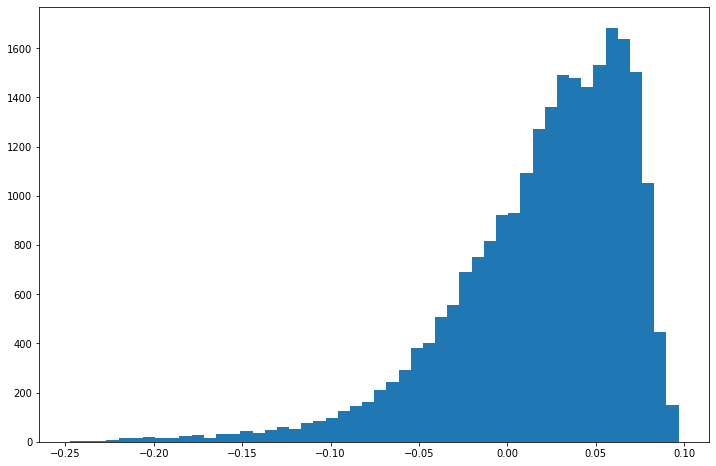

In [7]:
scores = clf.decision_function(dataset[features])
plt.figure(figsize=(12, 8))
plt.hist(scores, bins=50);

In [9]:
dataset['state'] = le1.inverse_transform(dataset['state'])

In [10]:
dataset['county'] = le2.inverse_transform(dataset['county'])

## Finding the total anomalies in each states ##

In [12]:
dataset.groupby('state').sum()

,party,votes,fraction_votes,anomaly,scores
state,,,,,
AK,70,22469,80.004,-269,-12.117634
AL,134,1223959,129.347,-129,-18.874151
AR,148,605971,141.735,110,-5.086954
AZ,30,834200,27.127,-19,-3.558249
CA,116,4938197,112.586,-68,-17.149329
CO,128,121184,61.570,60,-0.701338
CT,338,531302,330.778,583,13.934841
DE,6,160416,5.868,-3,-0.620156
FL,134,3940929,127.931,56,-7.997250


In [13]:
sum_correct = dataset[dataset['anomaly']>=0].groupby('state').sum()
sum_incorrect = dataset[dataset['anomaly']==-1].groupby('state').sum()

In [14]:
correct_list = list(sum_correct['anomaly'])
correct_list.insert(0, 0) #since AK did not have a single inliner. 
incorrect_list = list(sum_incorrect['anomaly'])

In [15]:
data2 = {'state': sorted(list(set(dataset['state']))),
         'inliers': correct_list,
         'outliers': incorrect_list
}
fin = pd.DataFrame(data2, columns = ['state', 'inliers', 'outliers'])

In [17]:
fin.head(5)

,state,inliers,outliers
0,AK,0,-269
1,AL,170,-299
2,AR,314,-204
3,AZ,28,-47
4,CA,111,-179


# To map this data to US states map #

Source: https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f?

In [18]:
from pylab import *
#!{sys.executable} -m pip install pyshp
#!{sys.executable} -m pip install graphviz

In [19]:
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "whitegrid", palette="pastel", color_codes=True)
sns.mpl.rc("figure", figsize=(10,6))
%matplotlib inline

In [20]:
shp_path = "./cb_2018_us_state_5m/cb_2018_us_state_5m.shp"
sf = shp.Reader(shp_path)
len(sf.shapes())

56

In [21]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [22]:
df = read_shapefile(sf)
df.head(56)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,coords
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"[(-104.053514, 41.157257), (-104.052666, 41.27..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"[(-122.328343, 48.021335), (-122.321721, 48.01..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"[(-109.050173, 31.480003999999997), (-109.0498..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"[(-104.057698, 44.997431), (-104.0502099999999..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"[(-106.645479, 31.89867), (-106.64084, 31.9045..."
5,06,01779778,0400000US06,06,CA,California,00,403503931312,20463871877,"[(-118.603375, 33.478097999999996), (-118.5987..."
6,21,01779786,0400000US21,21,KY,Kentucky,00,102279490672,2375337755,"[(-89.405654, 36.528165), (-89.398685, 36.5423..."
7,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"[(-82.73570699999999, 41.603361), (-82.718802,..."
8,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"[(-88.04374299999999, 30.517422999999997), (-8..."
9,13,01705317,0400000US13,13,GA,Georgia,00,149482048342,4422936154,"[(-85.605165, 34.984677999999995), (-85.552592..."


In [23]:
states = df['STUSPS']
states

for i in states: 
    if (i not in list(set(dataset['state']))):
        print(df[df.STUSPS == i].STATEFP)

25    27
Name: STATEFP, dtype: object
39    78
Name: STATEFP, dtype: object
46    11
Name: STATEFP, dtype: object
47    66
Name: STATEFP, dtype: object
48    69
Name: STATEFP, dtype: object
49    60
Name: STATEFP, dtype: object
51    72
Name: STATEFP, dtype: object


In [25]:
# Missing data 
df.drop([46, 47, 48, 49, 51]).head(5)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,coords
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"[(-104.053514, 41.157257), (-104.052666, 41.27..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"[(-122.328343, 48.021335), (-122.321721, 48.01..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"[(-109.050173, 31.480003999999997), (-109.0498..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"[(-104.057698, 44.997431), (-104.0502099999999..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"[(-106.645479, 31.89867), (-106.64084, 31.9045..."


In [26]:
def plot_shape(id, s=None):
    """ PLOTS A SINGLE SHAPE """
    plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    plt.plot(x_lon,y_lat) 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
    # use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])
    return x0, y0

In [27]:
df[df.NAME == "New York"]

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,coords
18,36,01779796,0400000US36,36,NY,New York,00,122049149763,19246994695,"[(-72.034958, 41.255458), (-72.029438, 41.2630..."


In [26]:
def calc_color(data, color=None):
        if color   == 1: 
            color_sq =  ['#dadaebFF','#bcbddcF0','#9e9ac8F0',
                        '#807dbaF0','#6a51a3F0','#54278fF0']
            colors = 'Purples'
        elif color == 2: 
            color_sq = ['#c7e9b4','#7fcdbb','#41b6c4',
                        '#1d91c0','#225ea8','#253494'] 
            colors = 'YlGnBu'
        elif color == 3: 
            color_sq = ['#f7f7f7','#d9d9d9','#bdbdbd',
                        '#969696','#636363','#252525'] 
            colors = 'Greys'
        elif color == 9: 
            color_sq = ['#ff0000','#ff0000','#ff0000',
                        '#ff0000','#ff0000','#ff0000']
        else:           
            color_sq = ['#ffffd4','#fee391','#fec44f',
                        '#fe9929','#d95f0e','#993404']
            colors = 'YlOrBr'
        new_data, bins = pd.qcut(data, 6, retbins=True, 
        labels=list(range(6)))
        color_ton = []
        for val in new_data:
            color_ton.append(color_sq[val]) 
        if color != 9:
            colors = sns.color_palette(colors, n_colors=6)
            sns.palplot(colors, 0.6);
            for i in range(6):
                print ("\n"+str(i+1)+': '+str(int(bins[i]))+
                       " => "+str(int(bins[i+1])-1), end =" ")
            print("\n\n   1   2   3   4   5   6")    
        return color_ton, bins;

In [27]:
def plot_comunas_data(sf, title, comunas, data=None, 
                      color=None, print_id=False):
    '''
    Plot map with selected comunes, using specific color
    '''
    
    color_ton, bins = calc_color(data, color)
    df = read_shapefile(sf)
    comuna_id = []
    for i in comunas:
        i = i.upper()
        comuna_id.append(df[df.STUSPS == 
                            i.upper()].index.get_values()[0])
    plot_map_fill_multiples_ids_tone(sf, title, comuna_id, 
                                     print_id, 
                                     color_ton, 
                                     bins, 
                                     x_lim = x_lim, 
                                     y_lim = y_lim, 
                                     figsize = (15,9));

In [28]:
def plot_map_fill_multiples_ids_tone(sf, title, comuna,  
                                     print_id, color_ton, 
                                     bins, 
                                     x_lim = None, 
                                     y_lim = None, 
                                     figsize = (15,9)):
    '''
    Plot map with lim coordinates
    '''
        
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    fig.suptitle(title, fontsize=16)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
    
        for id in comuna:
            shape_ex = sf.shape(id)
            x_lon = np.zeros((len(shape_ex.points),1))
            y_lat = np.zeros((len(shape_ex.points),1))
            for ip in range(len(shape_ex.points)):
                x_lon[ip] = shape_ex.points[ip][0]
                y_lat[ip] = shape_ex.points[ip][1]
            ax.fill(x_lon,y_lat, color_ton[comuna.index(id)])
        if print_id != False:
            x0 = np.mean(x_lon)
            y0 = np.mean(y_lat)
            plt.text(x0, y0, id, fontsize=10)
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

## Inliers per state on US Map ##

The most purple-shaded states have the most amount of normal data points.


1: 0 => 73 
2: 74 => 120 
3: 121 => 228 
4: 229 => 405 
5: 406 => 652 
6: 653 => 2588 

   1   2   3   4   5   6


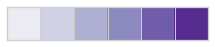

<Figure size 1080x648 with 0 Axes>

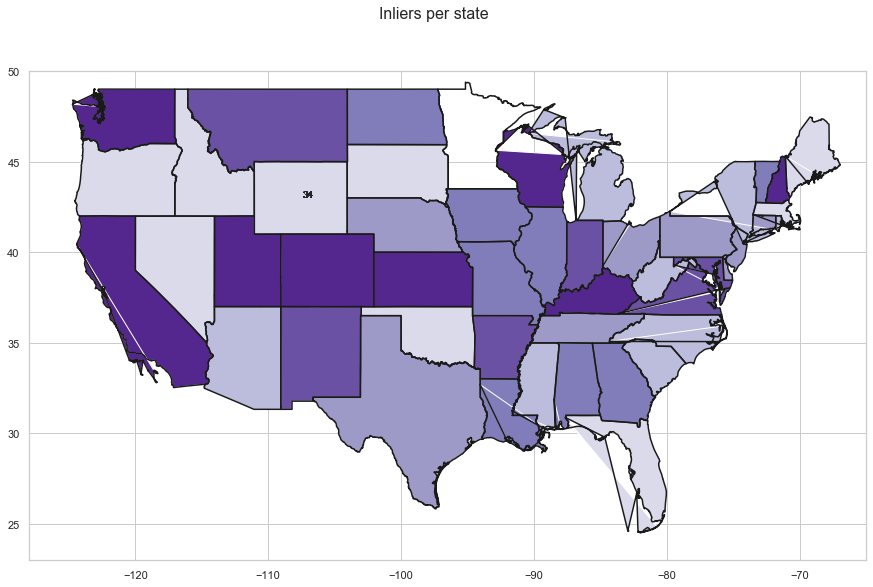

In [29]:
y_lim = (23, 50) # lat 
x_lim = (-128, -65) # long
my_states = list(set(dataset['state']))
color_pallete = 1
plot_comunas_data(sf, "Inliers per state", my_states, correct_list, color_pallete, True)

# Outliers per state on US Map #

The darkest shaded states has the least amount of anomalies due to the negative values


1: -456 => -181 
2: -180 => -115 
3: -114 => -62 
4: -61 => -44 
5: -43 => -26 
6: -25 => -3 

   1   2   3   4   5   6


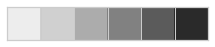

<Figure size 1080x648 with 0 Axes>

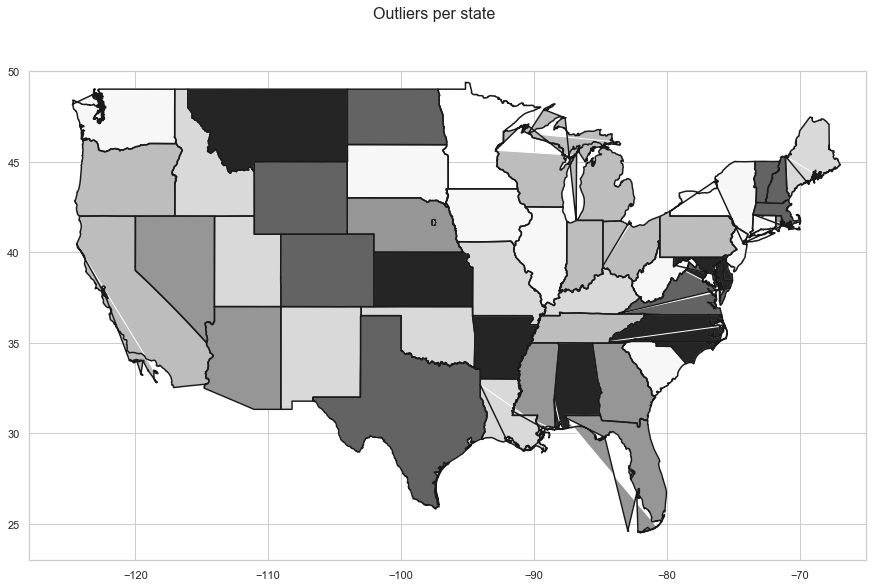

In [39]:
y_lim = (23, 50) # lat 
x_lim = (-128, -65) # long
my_states = list(set(dataset['state']))
color_pallete = 3
plot_comunas_data(sf, "Outliers per state", my_states, incorrect_list, color_pallete, True)

# Conclusion #

Model's accuracy is unknown therefore results are not trustworthy. Given the entire dataset, 28.5% is anomalous can signal either the data is faulty or the model is inaccurate. Further research and analyzing data will hopefully provide the desired answers. 